In [1]:
from lmfit import minimize, Parameters

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX

import os 
os.chdir('..')
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_yeast_1.05.csv')

In [3]:
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

In [5]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [6]:
en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


## Using lmfit to predict elasticity values w/o ey values

In [7]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

    #model = np.diag(v_star)@(np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T)
    #return (df[fluxes].loc[1:].values-model.T)

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

7.162129346270159e-07


In [8]:
lmfit_ex = np.array([i.value for i in out.params.values()])
np.where(np.abs(lmfit_ex) > 0.01)

(array([  0,   1,  12,  13,  23,  34,  46,  47,  58,  59,  70,  71,  82,
         83,  94,  95, 106, 107, 118, 119, 130, 131, 142, 143, 164, 169],
       dtype=int64),)

In [9]:
out.params['Ex13'].value

-0.9540906588775258

In [10]:
ex

               GLCi,      G6P,       F6P,     F16P,      TRIO,       BPG,      P3G,       P2G,       PEP,       PYR,      ACE
vGLK   [[   1.44964, -1.43765,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vPGI    [         0,  1.40347, -0.953057,        0,         0,         0,        0,         0,         0,         0,        0],
vGLYCO  [         0,        1,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vTreha  [         0,        1,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vPFK    [         0,        0,   1.38303, -1.03688,         0,         0,        0,         0,         0,         0,        0],
vALD    [         0,        0,         0,  1.10649, -0.823896,         0,        0,         0,         0,         0,        0],
vGAPDH  [         0,        0,         0,        0,  0.969712, -0.705532,        0,         0,         0, 

Now, we are going to explore control coefficient values for each set of elasticity values predicted by lmfit

In [11]:
def estimate_CCs(Ex):
    vn[vn == 0] = 1e-6
    
    a = np.diag(en.values / vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1, axis=0)

    Ex_ss = a @ Ex
    As = N @ np.diag(v_star) @ Ex_ss
    bs = N @ np.diag(v_star)
    bs = bs[np.newaxis, :].repeat(1, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(N.T))
    identity = identity[np.newaxis,:].repeat(1, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return -FCC

In [12]:
lmfit_ex_df = pd.DataFrame(lmfit_ex.reshape((16,11)), index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
FCC_estimates = np.squeeze(estimate_CCs(lmfit_ex_df.values))

In [13]:
FCC_estimates[0]

array([-1.80606096e+00,  5.13373389e-02,  1.91238828e-02,  1.95488580e-01,
        3.53763380e-02,  3.31154584e-02,  1.61423796e-02,  1.22314548e-02,
        8.61649212e-03,  5.27647093e-03,  5.60849004e-03,  3.49773169e-03,
        3.15888202e-04,  4.07186661e-01,  7.61420852e-04,  1.19823764e-02])

In [14]:
r.getScaledFluxControlCoefficientMatrix()[0]

[1.97827702e-01 5.10757773e-02 1.89554933e-02 1.93767264e-01
 3.51968189e-02 3.29828174e-02 1.58676664e-02 1.20388199e-02
 8.49372163e-03 5.19193084e-03 5.57501480e-03 3.47188097e-03
 2.80782735e-04 4.06810162e-01 6.76802198e-04 1.17873451e-02]

In [15]:
FCC_estimates[5]

array([ 1.07719943e-01,  2.36109151e-01, -1.58929312e-02, -1.62461075e-01,
        1.62721844e-01, -1.84767916e+00,  7.42276875e-02,  5.62219789e-02,
        3.95763293e-02,  2.41947930e-02,  2.57223537e-02,  1.60017425e-02,
        1.40114919e-03,  2.23765138e-01,  3.37734744e-03,  5.49937106e-02])

In [16]:
r.getScaledFluxControlCoefficientMatrix()[5]

[ 0.10793611  0.23703552 -0.01581667 -0.1616815   0.1633435   0.15306863
  0.07363961  0.05587047  0.03941817  0.02409502  0.02587286  0.01611251
  0.00130307  0.22195833  0.00314094  0.05470341]

With the exception of the reaction being perturbed, the predicted FCC values match up quite well with the ground truth FCC values. 

## Using a dataset with variable perturbation strengths


In [17]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_yeast_mixed.csv')

r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]



In [18]:
v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [19]:
def residual(params, xn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

    #model = np.diag(v_star)@(np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T)
    #return (df[fluxes].loc[1:].values-model.T)

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

0.0023103310061918453


## Removing perturbations from certain enzymes. 

In [20]:
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [21]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_yeast_missing3.csv')

v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [22]:
def residual(params, xn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

0.00039463347995048336


In [23]:
mis3_ex = np.array([i.value for i in out.params.values()]).reshape((16,11))
mis3_ex = pd.DataFrame(mis3_ex, columns=r.getFloatingSpeciesIds(), index=r.getReactionIds())
mis3_ex

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,1.539948,-1.604117,0.002775,-0.002644,-0.006548,0.000134,-0.001218,-0.038112,0.029403,-0.000099,-0.000093
vPGI,-0.002822,1.400024,-0.941441,-0.033149,0.019292,0.000627,-0.001031,0.002425,-0.001699,-0.000004,-0.000003
vGLYCO,0.030555,1.050610,-0.007963,0.007155,-0.000657,-0.000152,0.003266,0.015563,-0.014897,0.000238,0.000216
vTreha,0.026246,1.056017,-0.003816,0.007633,0.000613,-0.000172,0.001103,0.024315,-0.018970,0.000076,0.000072
vPFK,-0.001787,-0.003154,1.340182,-1.055313,0.053554,0.001817,-0.002676,0.055798,-0.041333,0.000031,0.000035
vALD,-0.001068,-0.001929,0.002729,1.110600,-0.822750,0.005929,-0.008130,-0.030550,0.022683,-0.000009,-0.000010
vGAPDH,-0.001779,-0.003172,0.004531,-0.018345,0.970912,-0.648302,-0.034657,-0.040192,0.029803,0.000013,0.000014
vPGK,-0.001350,-0.002414,0.003441,-0.014324,0.014354,0.833785,-0.593567,0.101816,-0.075670,0.000148,0.000164
vPGM,-0.001090,-0.001954,0.002781,-0.011894,0.011890,0.002419,0.930597,-0.660776,0.007194,0.000271,0.000300
vENO,-0.000607,-0.001084,0.001547,-0.006427,0.006441,0.001360,-0.002075,1.057745,-0.784660,0.000593,0.000669


## How many perturbations do you even need?

In [24]:
missing_data_filenames = [
    '../data/Simplified_Teusink_yeast_1.05.csv',
    '../data/Simplified_Teusink_yeast_missing3.csv',
    '../data/Simplified_Teusink_yeast_missing6.csv',
    '../data/Simplified_Teusink_yeast_missing9.csv',
    '../data/Simplified_Teusink_yeast_missing12.csv'
]

In [25]:
mis_exs = [ex.flatten()]
for f in missing_data_filenames:
    df = pd.read_csv(f)

    v_star = df[fluxes].loc[0]

    ex = r.getScaledElasticityMatrix()

    a = r.getBoundarySpeciesIds()
    b = r.getReactionIds()
    c=[]
    for i in b: 
        for ii in a: 
            c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
    ey = np.array(c).reshape((len(b),len(a)))

    en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
    xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
    vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
    yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]
    
    out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)
    mis_exs.append(np.array([i.value for i in out.params.values()]))

In [26]:
mis_results = pd.DataFrame(mis_exs)
mis_results

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,1.449644,-1.437645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.461108,-1.453929,-0.000169,-0.000024,-0.000531,-0.000069,-0.000084,-0.000126,0.000015,-0.000077,...,-0.008914,0.003209,0.000394,0.999845,0.001142,0.001000,0.001109,-0.000115,0.000585,0.002203
2,1.539948,-1.604117,0.002775,-0.002644,-0.006548,0.000134,-0.001218,-0.038112,0.029403,-0.000099,...,0.033955,-0.049456,0.171472,0.865629,-0.019124,0.028644,0.038231,-0.029005,0.000027,0.000022
3,1.568559,-9.768224,5.475394,0.301089,4.588298,-2.533875,-0.100082,0.774685,-0.574883,0.000583,...,5.050747,-3.409659,-0.027794,-0.938000,0.851019,0.054953,-1.622156,1.203483,-0.001060,-0.001178
4,1.543411,-1.597797,-0.850407,0.683284,-0.231257,0.196580,0.013591,0.825212,-0.612124,-0.010507,...,0.033856,0.081933,0.063328,1.251614,-0.285852,0.014058,-0.500292,0.371182,0.007193,-0.002390
5,1.450789,-1.063106,0.477022,-0.368915,0.095643,-0.077882,-0.005619,-0.286662,0.212637,0.003624,...,9.326050,-0.176398,3.636492,-0.821293,-0.374492,-0.008391,0.589945,-0.437634,-0.007798,0.002588


In [27]:
mis_difs = [i - ex.flatten() for i in mis_exs]
mis_difs_df = pd.DataFrame(mis_difs)
mis_difs_df

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.011465,-0.016284,-0.000169,-0.000024,-0.000531,-0.000069,-0.000084,-0.000126,0.000015,-0.000077,...,-0.008914,0.003209,0.000394,-0.000155,0.001142,0.001000,0.001109,-0.000115,0.000585,0.002203
2,0.090305,-0.166472,0.002775,-0.002644,-0.006548,0.000134,-0.001218,-0.038112,0.029403,-0.000099,...,0.033955,-0.049456,0.171472,-0.134371,-0.019124,0.028644,0.038231,-0.029005,0.000027,0.000022
3,0.118915,-8.330579,5.475394,0.301089,4.588298,-2.533875,-0.100082,0.774685,-0.574883,0.000583,...,5.050747,-3.409659,-0.027794,-1.938000,0.851019,0.054953,-1.622156,1.203483,-0.001060,-0.001178
4,0.093767,-0.160152,-0.850407,0.683284,-0.231257,0.196580,0.013591,0.825212,-0.612124,-0.010507,...,0.033856,0.081933,0.063328,0.251614,-0.285852,0.014058,-0.500292,0.371182,0.007193,-0.002390
5,0.001145,0.374539,0.477022,-0.368915,0.095643,-0.077882,-0.005619,-0.286662,0.212637,0.003624,...,9.326050,-0.176398,3.636492,-1.821293,-0.374492,-0.008391,0.589945,-0.437634,-0.007798,0.002588


Text(0.5, 1.0, 'absolute error of ex values when perturbation data is missing')

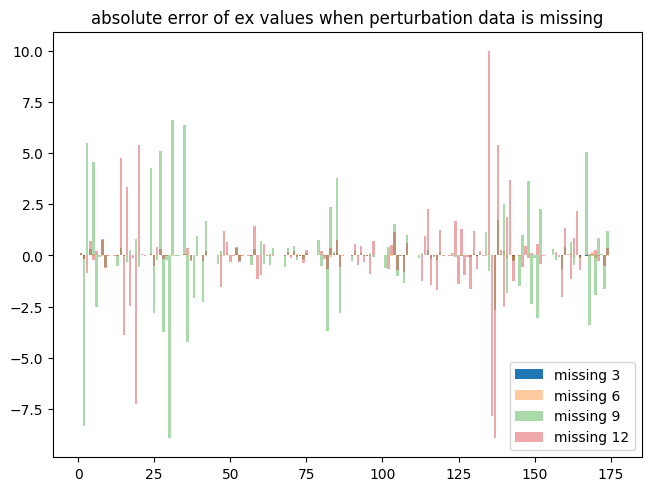

In [28]:
fig, ax = plt.subplots(layout='constrained')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[1], label='missing 3')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[2], alpha=0.4, label='missing 6')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[3], alpha=0.4, label='missing 9')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[4], alpha=0.4, label='missing 12')
ax.legend(loc='lower right')
ax.set_title('absolute error of ex values when perturbation data is missing')

### Examining which elasticities the omitted perturbations affect

In [38]:
np.where(np.abs(mis_difs_df.iloc[1].values)>0.001)

(array([  0,   1,  12,  13,  22,  33,  45,  46,  47,  48,  58,  59,  70,
         71,  82,  83,  84,  94,  95, 106, 107, 108, 109, 118, 119, 120,
        130, 131, 132, 134, 139, 142, 164, 165, 166, 167, 170, 171, 172,
        175], dtype=int64),)

vTreha: 2.0 G6P ->
vENO: P2G -> PEP
vG3PDH: TRIO ->

In [43]:
ex_df = pd.DataFrame(ex, columns=r.getFloatingSpeciesIds(), index=r.getReactionIds())
ex_df[ex_df.abs() > 0]


,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,1.449644,-1.437645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vPGI,NaN,1.403469,-0.953057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vGLYCO,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vTreha,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vPFK,NaN,NaN,1.383026,-1.036885,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vALD,NaN,NaN,NaN,1.106486,-0.823896,NaN,NaN,NaN,NaN,NaN,NaN
vGAPDH,NaN,NaN,NaN,NaN,0.969712,-0.705532,NaN,NaN,NaN,NaN,NaN
vPGK,NaN,NaN,NaN,NaN,NaN,0.929921,-0.660320,NaN,NaN,NaN,NaN
vPGM,NaN,NaN,NaN,NaN,NaN,NaN,0.935924,-0.653604,NaN,NaN,NaN
vENO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.069260,-0.795416,NaN,NaN


In [42]:
mis3_df = pd.DataFrame(mis_difs_df.iloc[1].values.reshape((16,11)), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds())
mis3_df[mis3_df.abs() > 0.001]

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,0.011465,-0.016284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vPGI,NaN,0.002648,-0.001034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vGLYCO,0.005287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vTreha,0.005437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vPFK,NaN,0.001047,-0.003697,0.004283,-0.001225,NaN,NaN,NaN,NaN,NaN,NaN
vALD,NaN,NaN,NaN,-0.003843,0.004164,NaN,NaN,NaN,NaN,NaN,NaN
vGAPDH,NaN,NaN,NaN,NaN,-0.001077,0.002374,NaN,NaN,NaN,NaN,NaN
vPGK,NaN,NaN,NaN,NaN,NaN,-0.002926,0.004322,-0.001003,NaN,NaN,NaN
vPGM,NaN,NaN,NaN,NaN,NaN,NaN,-0.004174,0.005637,NaN,NaN,NaN
vENO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006427,0.010034,-0.001373,-0.001177


The general pattern I see regarding the poor fits is that they usually occur in the positions of nonzero elasticities. 

## Using Bayesian inference

Now that we have the math squared away, we will use Bayesian inference and see if we can get comparable results to lmfit.


In [1]:
# switch kernel to pytensor5 here
import cobra
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pytensor
import pymc as pm

import emll

import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('../data/Simplified_Teusink_yeast_1.05.csv')
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [3]:
# load cobra version of model

model = cobra.io.read_sbml_model('../models/Simplified_Teusink_yeast_cobra.xml')
# cobra.util.create_stoichiometric_matrix(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


No objective coefficients in model. Unclear what should be optimized


In [4]:
# Set up the Bayesian inference
r_compartments = [r.compartments if 'e' not in r.compartments else 't' for r in model.reactions]

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = 't'

m_compartments = [m.compartment for m in model.metabolites]
internal_mets = [i for i in model.metabolites if i.compartment!='e']
rxnNames = [i.id for i in model.reactions]
v_inds = np.arange(0,len(v_star))
n_exp = vn.shape[0]


In [48]:
def create_Visser_elasticity_matrix():

    r = te.loada('../models/Simplified_Teusink_yeast_cobra.ant')
    r.conservedMoietyAnalysis = True
    
    n_metabolites = len(model.metabolites)
    n_reactions = len(model.reactions)
    array = np.zeros((n_reactions, n_metabolites), dtype=float)

    m_ind = model.metabolites.index
    r_ind = model.reactions.index

    for reaction in model.reactions:
        for metabolite, stoich in reaction.metabolites.items():

            # Reversible reaction, assign all elements to -stoich
            if reaction.reversibility:
                array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

            # Irrevesible in forward direction, only assign if met is reactant
            elif ((not reaction.reversibility) & 
                (reaction.upper_bound > 0) &
                (stoich < 0)):
                array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

            # Irreversible in reverse direction, only assign if met is product
            elif ((not reaction.reversibility) & 
                (reaction.lower_bound < 0) &
                (stoich > 0)):
                array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

    array = emll.util.create_elasticity_matrix(model)
    array = pd.DataFrame(array, index=r.getReactionIds(), columns=[i.id for i in model.metabolites])
    array = array.loc[:,r.getFloatingSpeciesIds()]
    return array

### actually running Bayesian inference

In [10]:
with pm.Model() as pymc_model:
    
    Ex_t = pm.Normal('Ex', mu=create_Visser_elasticity_matrix().values)
    Ey_t = pm.Normal('Ey', mu=np.zeros((16,3)), sigma=4)

    likelihood = (en.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
    vn_t = pm.Normal('vn_t', mu=likelihood, sigma=0.1, observed=vn)


In [13]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

Finished [100%]: Average Loss = 305.15


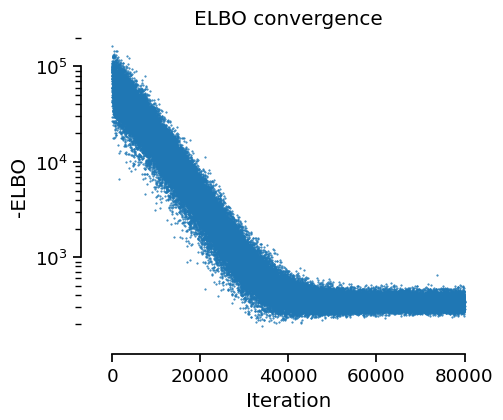

In [16]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [18]:
idata = approx.sample(1000)

In [19]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Ex[0, 0]",-0.967,0.028,-1.017,-0.914,0.001,0.001,1010.0,1026.0,NaN
"Ex[0, 1]",0.011,0.029,-0.046,0.065,0.001,0.001,982.0,983.0,NaN
"Ex[0, 2]",0.005,0.028,-0.046,0.058,0.001,0.001,921.0,972.0,NaN
"Ex[0, 3]",0.000,0.027,-0.054,0.052,0.001,0.001,859.0,958.0,NaN
"Ex[0, 4]",-0.008,0.027,-0.061,0.040,0.001,0.001,923.0,1015.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ey[14, 1]",0.154,4.493,-7.396,9.031,0.148,0.105,924.0,940.0,NaN
"Ey[14, 2]",0.077,4.450,-8.241,8.146,0.139,0.100,1021.0,936.0,NaN
"Ey[15, 0]",-0.073,4.306,-7.962,8.225,0.134,0.105,1020.0,852.0,NaN
"Ey[15, 1]",0.202,4.241,-7.962,7.692,0.131,0.106,1046.0,910.0,NaN


Perhaps it is failing to fit Ex when Ey is also being fitted just like lmfit. Let's fix Ey and see if pymc performs better with fitting Ex. 


In [68]:
with pm.Model() as pymc_model:
    
    Ex_t = pm.Normal('Ex', mu=create_Visser_elasticity_matrix().values)

    likelihood = (en.values*v_star.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
    v = pm.Normal('v', mu=likelihood, sigma=0.1, observed=vn*v_star)
    

In [69]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

Finished [100%]: Average Loss = 377.1


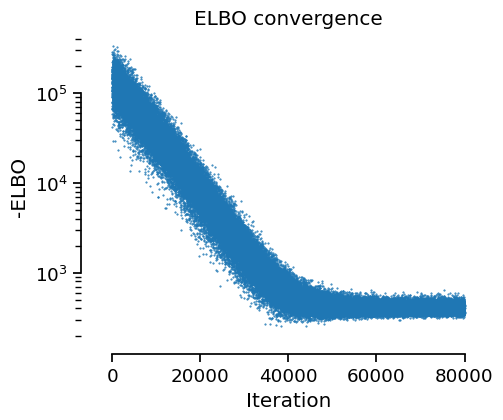

In [70]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [71]:
idata = approx.sample(1000)

In [72]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Ex[0, 0]",-0.924,0.019,-0.960,-0.888,0.001,0.0,1106.0,936.0,NaN
"Ex[0, 1]",0.011,0.020,-0.027,0.047,0.001,0.0,847.0,907.0,NaN
"Ex[0, 2]",0.005,0.020,-0.031,0.041,0.001,0.0,971.0,1014.0,NaN
"Ex[0, 3]",-0.000,0.020,-0.035,0.038,0.001,0.0,956.0,748.0,NaN
"Ex[0, 4]",-0.006,0.019,-0.041,0.030,0.001,0.0,975.0,1020.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ex[15, 6]",-0.079,0.018,-0.113,-0.044,0.001,0.0,1186.0,1025.0,NaN
"Ex[15, 7]",-0.076,0.020,-0.112,-0.038,0.001,0.0,908.0,983.0,NaN
"Ex[15, 8]",-0.075,0.019,-0.107,-0.039,0.001,0.0,1099.0,926.0,NaN
"Ex[15, 9]",-0.083,0.019,-0.121,-0.049,0.001,0.0,1029.0,923.0,NaN


Checking whether the pymc ex values can be plugged back into the linlog equation
to give the real flux values. 

In [74]:
Ex_pytensor = np.squeeze(idata['posterior']['Ex'].to_numpy())
Ex_pytensor.shape

(1000, 16, 11)

In [75]:
Ex_pytensor = az.summary(idata)['mean'].values
Ex_pytensor = Ex_pytensor.reshape((16,11))


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [76]:
a = (en.values*v_star.values)*(np.ones((16,16)) + (ex@xn.T).values + (ey@yn.T).values)
a[0]

array([2.31282037, 1.05995151, 0.10984542, 0.56611844, 1.05915662,
       1.05904386, 1.72279794, 1.72248333, 1.7221924 , 1.72192348,
       1.7219502 , 1.72178022, 0.25239272, 2.33553511, 1.2167638 ,
       0.39350587])

In [77]:
b = (en.values*v_star.values)*(np.ones((16,16)) + (Ex_pytensor@xn.T).values + (ey@yn.T).values)
b[0]

array([2.44586353, 1.07989631, 0.10915869, 0.55595515, 1.07104964,
       1.06983621, 1.75957314, 1.66433166, 1.68103232, 1.69466914,
       1.69458176, 1.70134439, 0.25093384, 2.24096165, 1.2083301 ,
       0.38655903])

*could this be a new elasticity matrix that hits the points but is not the actual value?*

In [78]:
(a-b).sum() # <-- this is the summed error

158.43930092373262

## initializing Ex with zeros instead of Visser matrix values

In [37]:
with pm.Model() as pymc_model:
    
    Ex_t = pm.Normal('Ex', mu=np.zeros((16,11)))

    likelihood = (en.values*v_star.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
    v = pm.Normal('v', mu=likelihood, sigma=0.1, observed=vn*v_star)
    

In [38]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

Finished [100%]: Average Loss = 369.59


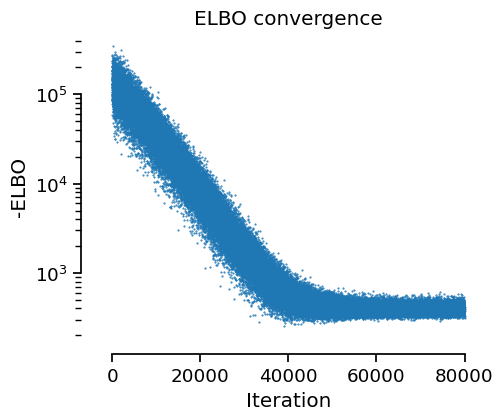

In [39]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [40]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Ex[0, 0]",0.032,0.020,-0.002,0.070,0.001,0.0,1018.0,841.0,NaN
"Ex[0, 1]",-0.006,0.019,-0.038,0.030,0.001,0.0,947.0,761.0,NaN
"Ex[0, 2]",-0.006,0.019,-0.042,0.032,0.001,0.0,798.0,942.0,NaN
"Ex[0, 3]",-0.006,0.019,-0.041,0.031,0.001,0.0,974.0,845.0,NaN
"Ex[0, 4]",-0.007,0.020,-0.042,0.031,0.001,0.0,858.0,825.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ex[15, 6]",0.000,0.019,-0.039,0.033,0.001,0.0,1011.0,1026.0,NaN
"Ex[15, 7]",-0.000,0.019,-0.034,0.036,0.001,0.0,915.0,1025.0,NaN
"Ex[15, 8]",-0.000,0.018,-0.034,0.035,0.001,0.0,1043.0,1002.0,NaN
"Ex[15, 9]",-0.003,0.019,-0.039,0.032,0.001,0.0,922.0,941.0,NaN


Nope, these results are even worse.

### Attempting to fit just one Ex value

In [84]:
def calculate_elasticity_mse():
    mse_list=[]
    mean_list=[]
    
    for i in range(16*11):
        with pm.Model() as pymc_model:
            
            Ex0_t = pm.Normal('Ex0', mu=create_Visser_elasticity_matrix().values.flatten()[:i+1], shape=(1,i+1))
            rest_ex = ex.flatten()[i+1:].reshape((1,175-i))
            # pm.Laplace('e_unmeasured', mu=0, b=0.1, shape = (n_exp, len(unknown_e_inds))) # 41, 43

            Ex_t = pytensor.tensor.concatenate([Ex0_t, rest_ex], axis=1).reshape((16,11))

        with pymc_model:
            likelihood = (en.values*v_star.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
            v = pm.Normal('v', mu=likelihood, sigma=0.1, observed=vn*v_star)

        with pymc_model:
            advi = pm.ADVI()
            tracker = pm.callbacks.Tracker(
                mean = advi.approx.mean.eval,
                std = advi.approx.std.eval
            )
            approx = pm.fit(n=80000)

        idata = approx.sample(1000)

        g_df = az.summary(idata)['mean'].reset_index()
        g_df.columns = ['elasticity', 'mean']
        g = g_df[g_df.elasticity.str.contains("Ex")]['mean'].values.flatten()

        mean_list.append(g)
        error = g - ex.flatten()[:len(g)]
        sq_error = error*error
        mse = sq_error.sum()/len(error)
        mse_list.append(mse)

    return mean_list, mse_list

It seems that Bayesian inference was able to guess the first elasticity.

Let's see how many elasticities Bayesian inference can infer until its predictions
degrade. 

In [85]:
mean_list, mse_list = calculate_elasticity_mse()

Finished [100%]: Average Loss = 8,972.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,974.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,978.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,983
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,987.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,991.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,995.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 9,000
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 9,003.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 9,008.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 9,012.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,686
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,689.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,693.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,697.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,701.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,705.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,710.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,713.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,718
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,722.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,726.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,072.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,075.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,078.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,082.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,087.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,092.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,095.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,099.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,103.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,106.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 7,111.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,452.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,454.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,458.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,463.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,466.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,471.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,476.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,479.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,482.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,486.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,491.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,297.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,301.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,305.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,310.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,314.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,318.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,323.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,326.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,331.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,335.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,339.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,211.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,216.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,220.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,225.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,228.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,234.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,237.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,241.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,244.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,249.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,253.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,143.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,147.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,151.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,156.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,159.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,164.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,168
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,172.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,175.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,181.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,184
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,067.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,071.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,076.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,079.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,084.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,087.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,092.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,097.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,102.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,106
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,108.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,980.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,983.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,988.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,992.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,997
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,000.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,005.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,008.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,012.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,016.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 5,021.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,898.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,902.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,906.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,910.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,916
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,919.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,921.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,926.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,933
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,936.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,938.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,787.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,788.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,793.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,798.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,804
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,808.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,812.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,814.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,821.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,824.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,828.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,466.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,470.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,474.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,479.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,481.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,485.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,491
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,495
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,499.1
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,503.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 4,506.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,857.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,858.6
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,862.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,868.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,872.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,876.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,879.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,883.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,890.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,892
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,897.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,899.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,905.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,906.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,912.5
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,914.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,922.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,925.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,930.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,934.2
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,937.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 2,940.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,947.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,955.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,954.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,963
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,967.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,971
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,974.3
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,976.7
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,982
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,985.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 1,990.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 339
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 342.36
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 346.02
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 349.34
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 352.31
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 356.14
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 362.07
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 366.09
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 368.16
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 375.55
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 379.21
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [90]:
mean_list[0:10]

[array([1.439]),
 array([-0.42 ,  0.419]),
 array([-0.572,  0.29 ,  0.278]),
 array([-0.65 ,  0.229,  0.216,  0.211]),
 array([-0.704,  0.187,  0.177,  0.171,  0.167]),
 array([-0.888,  0.006, -0.003, -0.01 , -0.021,  0.921]),
 array([-0.894,  0.012,  0.005, -0.002, -0.011,  0.937, -0.039]),
 array([-0.9  ,  0.014,  0.007,  0.   , -0.007,  0.946, -0.033, -0.017]),
 array([-0.91 ,  0.013,  0.005,  0.001, -0.007,  0.951, -0.031, -0.017,
        -0.011]),
 array([-0.916,  0.013,  0.006,  0.001, -0.006,  0.955, -0.027, -0.015,
        -0.009,  0.004])]

When the model only had one unknown, it was able to guess the correct elasticity value. 


But, when there were two or more unknowns, the model was not able to guess the correct elasticity values. 

The MSE values for these runs are appropriately low, even if the elasticity values are incorrect.

In [91]:
mse_list[0:10]

[0.0001132844507317506,
 3.471348936375291,
 2.3830280228262377,
 1.8193464390111969,
 1.473222213649553,
 1.399579893270768,
 1.2105394032735235,
 1.0655612656849254,
 0.9531261895149871,
 0.8613789427836969]

Conclusion: Bayesian inference is only able to fit the elasticity values when only one elasticity value is missing. 

Could the prediction values improve if Bayesian inference happens on a column basis as opposed to a single-value basis?

### Fitting by column

In [106]:
def calculate_elasticity_mse_by_column():
    mse_list=[]
    mean_list=[]
    
    for i in range(15):
        with pm.Model() as pymc_model:
            
            Ex0_t = pm.Normal('Ex0', mu=create_Visser_elasticity_matrix().values[i+1], shape=(i+1, 11))
            rest_ex = ex[i+1:,:]
            # pm.Laplace('e_unmeasured', mu=0, b=0.1, shape = (n_exp, len(unknown_e_inds))) # 41, 43

            Ex_t = pytensor.tensor.concatenate([Ex0_t, rest_ex], axis=0)

        with pymc_model:
            likelihood = (en.values*v_star.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
            v = pm.Normal('v', mu=likelihood, sigma=0.1, observed=vn*v_star)

        with pymc_model:
            advi = pm.ADVI()
            tracker = pm.callbacks.Tracker(
                mean = advi.approx.mean.eval,
                std = advi.approx.std.eval
            )
            approx = pm.fit(n=80000)

        idata = approx.sample(1000)

        g_df = az.summary(idata)['mean'].reset_index()
        g_df.columns = ['elasticity', 'mean']
        g = g_df[g_df.elasticity.str.contains("Ex")]['mean'].values.flatten()

        mean_list.append(g)
        error = g - ex.flatten()[:len(g)]
        sq_error = error*error
        mse = sq_error.sum()/len(error)
        mse_list.append(mse)

    return mean_list, mse_list

In [109]:
col_mean_list, col_mse_list = calculate_elasticity_mse_by_column()

Finished [100%]: Average Loss = 9,010.8
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


Finished [100%]: Average Loss = 8,724.9
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [115]:
col_mean_list[0]

array([ 0.984, -0.026, -0.024, -0.021, -0.02 ,  0.01 , -0.956,  0.026,
        0.019,  0.002, -0.008])

In [116]:
col_mean_list[1]

array([ 0.905, -0.106, -0.103, -0.102, -0.1  , -0.089, -0.084, -0.079,
       -0.076, -0.082, -0.09 ,  0.88 , -0.096, -0.104, -0.101, -0.098,
       -0.087, -0.08 , -0.077, -0.075, -0.079, -0.087])

Conclusion: the column-basis Bayesian inference does not demonstrate improved prediction over the 
single-value Bayesian inference predictions

What happens if you seed all the Bayesian priors with ground truth values?

In [6]:
with pm.Model() as pymc_model:
    
    Ex_t = pm.Normal('Ex', mu=ex)

    likelihood = (en.values*v_star.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
    v = pm.Normal('v', mu=likelihood, sigma=0.1, observed=vn*v_star)
    

In [7]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

Finished [100%]: Average Loss = 365.75


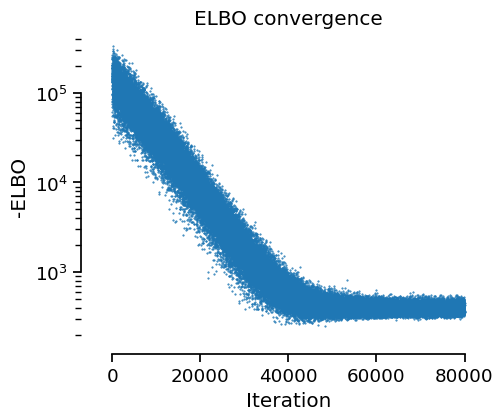

In [8]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [9]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Ex[0, 0]",1.443,0.019,1.409,1.479,0.001,0.0,1028.0,961.0,NaN
"Ex[0, 1]",-1.441,0.020,-1.479,-1.406,0.001,0.0,971.0,812.0,NaN
"Ex[0, 2]",-0.002,0.019,-0.037,0.033,0.001,0.0,948.0,872.0,NaN
"Ex[0, 3]",-0.004,0.019,-0.037,0.033,0.001,0.0,1011.0,836.0,NaN
"Ex[0, 4]",-0.004,0.019,-0.044,0.028,0.001,0.0,1031.0,972.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ex[15, 6]",-0.080,0.021,-0.122,-0.048,0.001,0.0,1075.0,983.0,NaN
"Ex[15, 7]",-0.073,0.019,-0.110,-0.038,0.001,0.0,868.0,980.0,NaN
"Ex[15, 8]",-0.072,0.020,-0.109,-0.033,0.001,0.0,950.0,917.0,NaN
"Ex[15, 9]",-0.077,0.020,-0.114,-0.039,0.001,0.0,1084.0,964.0,NaN


In [16]:
g = pd.DataFrame((az.summary(idata)['mean'].values).reshape((16,11)))
g[g.abs() < 0.01] = 0
g

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,0,1,2,3,4,5,6,7,8,9,10
0,1.443,-1.441,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,-0.043,1.358,-0.997,-0.044,-0.044,-0.041,-0.039,-0.038,-0.036,-0.038,-0.041
2,-0.103,0.894,-0.101,-0.099,-0.101,-0.089,-0.083,-0.079,-0.078,-0.086,-0.097
3,-0.104,0.898,-0.098,-0.096,-0.096,-0.087,-0.082,-0.078,-0.078,-0.087,-0.106
4,-0.033,-0.033,1.348,-1.072,-0.035,-0.032,-0.030,-0.030,-0.030,-0.030,-0.032
5,-0.025,-0.024,-0.027,1.080,-0.850,-0.024,-0.023,-0.022,-0.021,-0.021,-0.022
6,-0.022,-0.023,-0.024,-0.024,0.945,-0.731,-0.025,-0.025,-0.024,-0.024,-0.022
7,-0.024,-0.025,-0.025,-0.025,-0.025,0.905,-0.686,-0.026,-0.025,-0.026,-0.026
8,-0.025,-0.023,-0.024,-0.023,-0.024,-0.024,0.911,-0.679,-0.025,-0.025,-0.026
9,-0.024,-0.024,-0.023,-0.022,-0.022,-0.024,-0.024,1.045,-0.820,-0.026,-0.027


why are we using Bayesian inference if it does not find values as well as lmfit??

## Solving elasticity values with pytensor/emll packages

In [2]:
model = cobra.io.read_sbml_model('../models/Simplified_Teusink_yeast_cobra.xml')

df = pd.read_csv('../data/Simplified_Teusink_yeast_1.05.csv')
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]

# Set up the Bayesian inference
r_compartments = [r.compartments if 'e' not in r.compartments else 't' for r in model.reactions]

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = 't'

m_compartments = [m.compartment for m in model.metabolites]
internal_mets = [i for i in model.metabolites if i.compartment!='e']
rxnNames = [i.id for i in model.reactions]
v_inds = np.arange(0,len(v_star))
n_exp = vn.shape[0]


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


No objective coefficients in model. Unclear what should be optimized


In [3]:
Ex = emll.create_elasticity_matrix(model)

Ey = np.zeros((16, 3))
Ey[13, 0] = -1  # glco on vGLT
Ey[14, 1] = 1  # etoh on vADH
Ey[15, 2] = 1  # gly on vG3PDH

ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star, driver='gelsy')

In [36]:
from emll.util import initialize_elasticity
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sigma=1, alpha=5))
    # Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sigma=1, alpha=5))
    Ey_t = pm.Laplace('Ey_t', mu=ey, b=0.001)

In [37]:
with pymc_model:
        
    # Error priors. 
    v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
    x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1)

    # Calculate steady-state concentrations and fluxes from elasticities
    chi_ss, v_hat_ss = ll.steady_state_pytensor(Ex_t, Ey_t, en.values, yn.values)

    # Error distributions for observed steady-state concentrations and fluxes
    chi_obs = pm.Normal('chi_obs', mu=chi_ss, sigma=x_err, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss[:, 0].squeeze(),
                          sigma=v_err, observed=vn.squeeze())

In [38]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

c:\Users\user\miniconda3\envs\pytensor5\lib\site-packages\pytensor\scalar\basic.py:2932: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.1801e+05


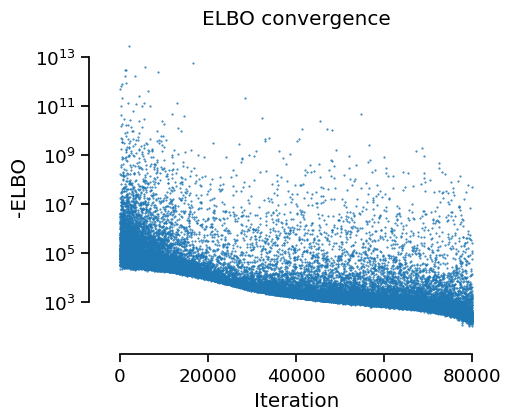

In [39]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [40]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ex_kinetic_entries[0],0.313,0.247,-0.122,0.804,0.008,0.006,918.0,848.0,NaN
ex_kinetic_entries[1],2.545,0.575,1.518,3.583,0.021,0.015,755.0,875.0,NaN
ex_kinetic_entries[2],0.533,0.433,-0.215,1.383,0.014,0.010,979.0,836.0,NaN
ex_kinetic_entries[3],1.261,0.702,-0.196,2.485,0.022,0.016,1025.0,855.0,NaN
ex_kinetic_entries[4],0.694,0.527,-0.283,1.685,0.017,0.012,1010.0,944.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ex[15, 6]",0.014,0.112,-0.172,0.254,0.004,0.003,834.0,849.0,NaN
"Ex[15, 7]",-0.011,0.088,-0.165,0.148,0.003,0.002,1095.0,983.0,NaN
"Ex[15, 8]",0.001,0.103,-0.184,0.197,0.004,0.003,811.0,906.0,NaN
"Ex[15, 9]",-0.019,0.154,-0.284,0.287,0.005,0.003,1050.0,931.0,NaN


In [41]:
g = az.summary(idata)['mean'].reset_index()
g.columns = ['elasticity', 'mean']
pd.DataFrame(g[g.elasticity.str.contains("Ex")]['mean'].values.reshape((16,11)), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds())

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,0.313,-2.545,-0.025,0.001,-0.012,-0.014,-0.013,0.019,0.028,0.009,-0.036
vPGI,-0.021,0.533,-1.261,-0.044,-0.070,-0.012,-0.023,0.007,0.052,0.058,-0.063
vGLYCO,-0.008,0.694,0.004,0.007,0.004,0.006,0.006,0.011,0.004,0.006,0.006
vTreha,-0.075,1.022,0.021,0.032,-0.019,-0.004,0.012,0.039,0.022,-0.017,-0.041
vPFK,0.019,0.005,0.677,-2.103,-0.021,-0.031,-0.015,0.017,-0.014,-0.027,0.018
vALD,0.012,0.002,-0.002,0.937,-1.214,-0.074,-0.055,-0.015,-0.014,0.019,0.024
vGAPDH,-0.025,-0.014,0.021,0.016,0.661,-0.589,-0.012,-0.001,0.001,0.049,0.046
vPGK,-0.002,-0.000,0.015,-0.007,0.008,1.817,-1.878,0.004,0.003,0.012,0.016
vPGM,-0.021,0.007,0.001,-0.003,0.016,0.011,0.957,-2.108,-0.024,0.008,-0.027
vENO,0.030,-0.003,0.010,0.009,0.003,0.010,-0.008,0.720,-1.587,-0.067,-0.046
